# SPAM/HAM CLASSIFICATION 
## Feature Engineering, Logistic Regression, Cross Validation

---
# Introduction 

In this project, we will create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition we will evaluate our work based on our model's accuracy.

After this project, we will feel comfortable with the following:

- Feature engineering with text data
- Using sklearn libraries to process data and fit models
- Validating the performance of our model and minimizing overfitting
- Generating and analyzing precision-recall curves

---
# Part I - Initial Analysis

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### I. 1) Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Our labeled training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

We run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labeled data that we will use to train our model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. We will predict labels for these emails.

In [2]:
original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


### I. 2) Missing Values

First, let's check if our data contains any missing values. We print the number of NaN values in each column. If there are NaN values, we replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns will be replaced with empty strings). We print the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.

In [3]:
original_training_data.isna().sum()

id         0
subject    6
email      0
spam       0
dtype: int64

In [4]:
original_training_data['subject'] = original_training_data['subject'].fillna('')

In [5]:
original_training_data.isna().sum()

id         0
subject    0
email      0
spam       0
dtype: int64

### I. 3) First Ham and Spam

In the cell below, we print the text of the first ham and the first spam email in the original training set.

In [6]:
print('First Ham:')
first_ham = original_training_data.loc[original_training_data['spam'] == 0, :].iloc[0,2]
print(first_ham)

First Ham:
url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 



In [7]:
print('First Spam:')
first_spam = original_training_data.loc[original_training_data['spam'] == 1, :].iloc[0,2]
print(first_spam)

First Spam:
<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



It looks like the spam email has HTML tags. If many spam emails have HTML tags, we can use them to predict whether an email is spam or ham.

### I. 4) Training Validation Split

The training data we downloaded is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets.  We will need this **validation data** to assess the performance of our classifier once we are finished training. Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every run.

In [8]:
from sklearn.model_selection import train_test_split

train, val = train_taest_split(original_training_data, test_size=0.1, random_state=42)

---
# Part II - Basic Feature Engineering

We would like to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so we can use logistic regression to train a classifier. We recall that to train a logistic regression model, we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $X$ is an email. Each column of $X$ contains one feature for all the emails. We'll first be creating a simple feature, and then we will create more interesting ones when we will be trying to increase the accuracy.

### Words in texts

We first create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

In [9]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = []
    for w in words:
        indicator_array.append(list(0 + texts.str.contains(w)))
    return np.array(indicator_array).T

In [10]:
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

---
# Part III - Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.

### III. 1) Bar Chart

Let's compare the proportion of emails in each class containing a particular set of words. We create a bar chart comparing the proportion of spam and ham emails containing certain words. We choose a set of words that are different from the ones above, but also have different proportions for the two classes. We only consider emails from `train`.

In [11]:
some_words = ['body', 'html', 'please', 'money', 'business', 'offer']

In [12]:
Words_in_Train = words_in_texts(some_words, train['email'])

df = pd.DataFrame(Words_in_Train, columns = some_words)

df['type'] = train['spam']
df['type'] = df['type'].replace(0, 'ham')
df['type'] = df['type'].replace(1, 'spam')

df.head()

,body,html,please,money,business,offer,type
0,0,0,0,0,0,0,ham
1,1,1,0,0,0,0,ham
2,0,0,1,0,0,0,spam
3,0,1,1,0,0,0,ham
4,1,1,0,0,1,1,ham


In [13]:
df_melt = df.melt('type')
df_melt.head()

,type,variable,value
0,ham,body,0
1,ham,body,1
2,spam,body,0
3,ham,body,0
4,ham,body,1


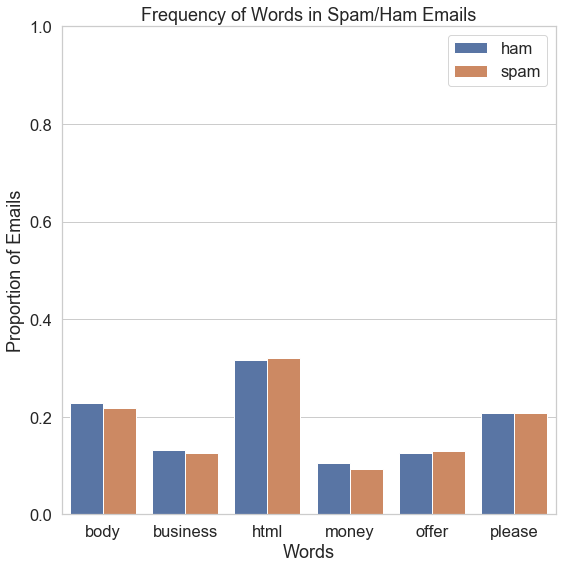

In [14]:
plt.figure(figsize=(8,8))

sns.barplot(x = "variable", 
            y = "value", 
            hue = "type", 
            data = df_melt
                    .groupby(['type', 'variable'])
                    .mean()
                    .reset_index())

plt.ylim([0, 1])
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.legend(title = "")
plt.title("Frequency of Words in Spam/Ham Emails")
plt.tight_layout()
plt.show()

When the feature is binary, it makes sense to compare its proportions across classes. Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

### III. 2) Conditional density

We create a *class conditional density plot* (using `sns.distplot`), comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set. 

(0, 50000)

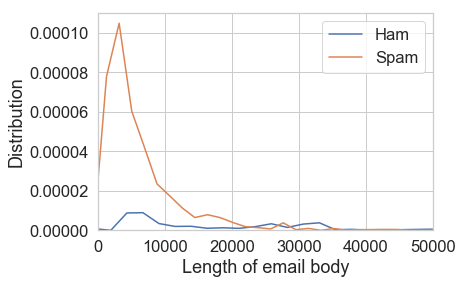

In [15]:
tmp = train.copy()

tmp['length'] = tmp['email'].str.len()
sns.distplot(tmp.loc[tmp['spam'] == 0, 'length'],hist=False, label='Ham')
sns.distplot(tmp.loc[tmp['spam'] == 1, 'length'],hist=False, label='Spam')
plt.xlabel('Length of email body')
plt.ylabel('Distribution')
plt.xlim((0,50000))

---
# Part IV - Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

### IV. 1) X_train and Y_train

We've used 5 words that might be useful as features to distinguish spam/ham emails. We use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

`X_train` will be a matrix of 0s and 1s created by using our `words_in_texts` function on all the emails in the training set.

`Y_train` will be a vector of the correct labels for each email in the training set.

In [16]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email']) 
Y_train = np.array(train['spam']) 

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), array([0, 0, 0, 0, 0], dtype=int64))

### IV. 2) Logistic Regression

Now we have matrices we can give to scikit-learn! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, we train a logistic regression model using `X_train` and `Y_train`. Then, we output the accuracy of the model (on the training data) in the cell below. 

In [17]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression() 
model.fit(X_train, Y_train) 

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


C:\Users\Elias\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


---
# Part V - Evaluating Classifiers

That doesn't seem too shabby! But the classifier we made above isn't as good as this might lead us to believe. First, we are evaluating accuracy on the training set, which may lead to a misleading accuracy measure, especially if we used the training set to identify discriminative features. In future parts of this analysis, it will be safer to hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The following image might help:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

### V. 1) Zero Predictor Classifier

Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? 

In [18]:
zero_predictor_fp = 0 
zero_predictor_fn = sum(Y_train == 1) 

What are the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set?

In [19]:
zero_predictor_acc = np.mean(Y_train == 0) 
zero_predictor_recall = 0 
print(zero_predictor_acc)

0.7447091707706642


**Remarks:**

- There are no false positives ($\text{FP} = 0$) because nothing is labeled spam. 
- Every spam email is mislabeled as ham, so the number of false negatives is equal to the number of spam emails in the training data ($\text{FN} = 1918$).
- The classifier correctly labels 74.47% of observations in the training data.
- The classifier recalls none (0%) of the spam observations.

### V. 2) Precision, recall, and False-alarm rate

We compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained above.

In [20]:
Y_train_hat = model.predict(X_train)

TP = sum((Y_train_hat == Y_train) & (Y_train_hat == 1))
TN = sum((Y_train_hat == Y_train) & (Y_train_hat == 0))
FP = sum((Y_train_hat != Y_train) & (Y_train_hat == 1))
FN = sum((Y_train_hat != Y_train) & (Y_train_hat == 0))

logistic_predictor_precision = TP / (TP + FP) 
logistic_predictor_recall = TP / (TP + FN) 
logistic_predictor_far = FP / (FP + TN) 

print(logistic_predictor_precision)

0.6422287390029325


### V. 3) Questions and Remarks

**Questions**:
1. Our logistic regression classifier got 75.6% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
1. Given the word features we have above, what could be one reason this classifier is performing poorly. 
1. Which of these two classifiers would we prefer for a spam filter?


**Remarks**:


1. An accuracy of 75% means that we're only doing slightly better than guessing ham for every email.
1. One reason why our classifier isn't great is that the matrix `X_train` has many rows with all 0. That is, the words we've chosen as our features aren't actually present in many of the emails so the classifier can't use them to distinguish between ham/spam emails.
1. The false-alarm rate for logistic regression is too high, even at 2%: ideally false-alarms would almost never happen. I might rather wade through thousands of spam emails than get 2% of legitimate emails filtered out of my inbox.

---
# Part VI - Moving Forward

With this in mind, it is now our task to make the spam filter more accurate. 

Here are some ideas for improving our model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. We can consider extracting out the text from the HTML to help you find better words. Or, we can match HTML tags themselves, or even some combination of the two.
1. Model selection. We can adjust parameters of our model (e.g. the regularization parameter) to achieve higher accuracy. Recall that we should use cross-validation to do feature and model selection properly! Otherwise, we will likely overfit to our training data.


### VI. 1) Precision-Recall Curve

We can trade off between precision and recall. In most cases we won't be able to get both perfect precision (i.e. no false positives) and recall (i.e. no false negatives), so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover a disease until it's too late to treat, while a false positive means that a patient will probably have to take another screening.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The precision-recall curve shows this trade off for each possible cutoff probability. In the cell below, we [plot a precision-recall curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#plot-the-precision-recall-curve) for our final classifier.

accuracy:  0.9242646080127779


C:\Users\Elias\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


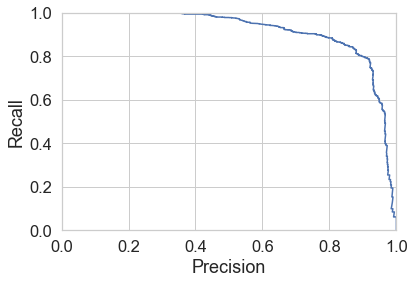

In [21]:
from sklearn.metrics import precision_recall_curve

staff_words = ['body', 'click', 'please', 'base64', '2002', 'html', 'subscribed',
               'wrote', 'mortgage', 'align3dcenterfont', 'dear', 'br', 'width10img',
               'divfont', 'im', 'receive', 'list', 'tags', 'web', 'base64', 'click',
               'body', 'please', 'money', 'offer', 'receive', 'contact', 'free',
               'tr', 'removed', 'remove', 'html', 'font', 'form',
               'credit', 'business', 'div']

X_train = words_in_texts(staff_words, train['email'])

staff_model = LogisticRegression()
staff_model.fit(X_train, Y_train)

print('accuracy: ', staff_model.score(X_train, Y_train))

Y_predict = staff_model.predict_proba(X_train)[:, 1]
prec, recall, _ = precision_recall_curve(Y_train, Y_predict)
plt.plot(prec, recall)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

### VI. 2) Predicting Test Data

In [22]:
test_predictions = staff_model.predict(words_in_texts(staff_words, test['email'])) 